<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Helper-Classes" data-toc-modified-id="Helper-Classes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Helper Classes</a></span></li><li><span><a href="#Question-1" data-toc-modified-id="Question-1-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Question 1</a></span><ul class="toc-item"><li><span><a href="#Importing-Data" data-toc-modified-id="Importing-Data-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Importing Data</a></span><ul class="toc-item"><li><span><a href="#Constants" data-toc-modified-id="Constants-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Test-Data" data-toc-modified-id="Test-Data-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Test Data</a></span></li><li><span><a href="#Training-/-Validation-Data" data-toc-modified-id="Training-/-Validation-Data-3.1.3"><span class="toc-item-num">3.1.3&nbsp;&nbsp;</span>Training / Validation Data</a></span></li></ul></li><li><span><a href="#Mixture-of-Gaussians" data-toc-modified-id="Mixture-of-Gaussians-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Mixture of Gaussians</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-3.2.1"><span class="toc-item-num">3.2.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Test-&amp;-Train-Accuracy" data-toc-modified-id="Test-&amp;-Train-Accuracy-3.2.2"><span class="toc-item-num">3.2.2&nbsp;&nbsp;</span>Test &amp; Train Accuracy</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-3.2.3"><span class="toc-item-num">3.2.3&nbsp;&nbsp;</span>Parameters</a></span></li></ul></li><li><span><a href="#Logistic-Regression" data-toc-modified-id="Logistic-Regression-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Logistic Regression</a></span><ul class="toc-item"><li><span><a href="#Model-Definition" data-toc-modified-id="Model-Definition-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Model Definition</a></span></li><li><span><a href="#Cross-Validation" data-toc-modified-id="Cross-Validation-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Cross Validation</a></span></li><li><span><a href="#Finding-the-Optimal-Lambda" data-toc-modified-id="Finding-the-Optimal-Lambda-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Finding the Optimal Lambda</a></span></li><li><span><a href="#Test-&amp;-Train-Accuracy-with-Optimal-Lambda" data-toc-modified-id="Test-&amp;-Train-Accuracy-with-Optimal-Lambda-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Test &amp; Train Accuracy with Optimal Lambda</a></span></li><li><span><a href="#Parameters" data-toc-modified-id="Parameters-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Parameters</a></span></li></ul></li><li><span><a href="#Discussion" data-toc-modified-id="Discussion-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Discussion</a></span></li></ul></li><li><span><a href="#Question-2b" data-toc-modified-id="Question-2b-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Question 2b</a></span><ul class="toc-item"><li><span><a href="#Experiment" data-toc-modified-id="Experiment-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Experiment</a></span></li></ul></li></ul></div>

# Imports

In [1]:
import pandas as pd
import numpy as np
from collections import Counter
from itertools import groupby
from operator import itemgetter
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from numpy.linalg import norm
from abc import ABC, abstractmethod 
import time

# Helper Classes

In [2]:
class DataFetcher:
    """
    DataFetcher: Grabs all csv data as pandas dataframes.
    """
    def __init__(self, directory, X_name, y_name):
        self.directory = directory
        self.X_name = X_name
        self.y_name = y_name
        
    def _get_training_X_path(self, subset_num):
        # 0 <= subset_num <= 9
        return './%s/train%s%d.csv' % (self.directory, self.X_name, (subset_num + 1))

    def _get_training_y_path(self, subset_num):
        # 0 <= subset_num <= 9
        return './%s/train%s%d.csv' % (self.directory, self.y_name, (subset_num + 1))

    def get_all_training_X_y(self):
        training_X_dfs = []
        training_y_dfs = []
        for i in range(NUM_SUBSETS):
            X_path = self._get_training_X_path(i)
            y_path = self._get_training_y_path(i)
            X_df = pd.read_csv(X_path, header=None)
            y_df =  pd.read_csv(y_path, header=None)
            training_X_dfs.append(X_df)
            training_y_dfs.append(y_df)
        
        return training_X_dfs, training_y_dfs
    
    def get_test_X_y(self):
        test_X_path = './%s/test%s.csv' % (self.directory, self.X_name)
        test_y_path = './%s/test%s.csv' % (self.directory, self.y_name)
        test_X_df = pd.read_csv(test_X_path, header=None)
        test_y_df = pd.read_csv(test_y_path, header=None)
        return test_X_df, test_y_df
    
class CrossValidationData:
    """
    CrossValidationData: Splits list of training dataframes 
        into validation & training dataframes.
    """
    def __init__(self, X_dfs, y_dfs):
        assert(len(X_dfs) == len(y_dfs))
        self.X = X_dfs
        self.y = y_dfs
        self.num_subsets = len(X_dfs)
        
    def _split_training_validation(self, dfs, subset_num):
        
        validation_df = dfs[subset_num]
        
        training_dfs = dfs[:subset_num] + dfs[subset_num+1:]
        training_df = pd.concat(training_dfs, ignore_index=True)
      
        return [training_df, validation_df]     
        
    def _get_training_validation_X(self, subset_num):
        assert(subset_num < self.num_subsets)
        
        [training_X, validation_X] = self._split_training_validation(self.X, subset_num)
        
        return [training_X, validation_X]
    
    def _get_training_validation_y(self, subset_num):
        assert(subset_num < self.num_subsets)
        
        [training_y, validation_y] = self._split_training_validation(self.y, subset_num)
        
        return [training_y, validation_y]
    
    def get_training_validation_X_y(self, subset_num):
        [training_X, validation_X] = self._get_training_validation_X(subset_num)
        [training_y, validation_y] = self._get_training_validation_y(subset_num)
        return [training_X, training_y, validation_X, validation_y]

    def get_all_X_y(self):
        training_X = pd.concat(self.X, ignore_index=True)
        training_y = pd.concat(self.y, ignore_index=True)
        return [training_X, training_y]
    
def get_accuracy(true_labels, predicted_labels):
    assert(len(true_labels) == len(predicted_labels))
    return sum(1 for y, y_hat in zip(true_labels, predicted_labels) if y == y_hat ) / len(true_labels)

class Model(ABC):
    """
    Model -> Abstract base class for the models we will implement, namely 
            KNN and RidgeRegression.
    """
    def __init__(self, train_X, train_y):
        self.train_X = train_X
        self.train_y = train_y
    
    @abstractmethod
    def predict(self, x):
        pass
        
    def predict_df(self, X_df):
        predictions = X_df.apply(lambda row: self.predict(row), raw=True, axis=1)
        return predictions

# Question 1

## Importing Data

### Constants

In [3]:
DIR_NAME = 'knn-dataset'
X_NAME = 'Data'
Y_NAME = 'Labels'
NUM_SUBSETS = 10
POSITIVE_LABEL = 6
NEGATIVE_LABEL = 5
LAMBDAS = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 11000, 12000, 13000, 14000, 15000]

### Test Data

In [4]:
DF = DataFetcher(DIR_NAME, X_NAME, Y_NAME)
test_X, test_y = DF.get_test_X_y()

test_X.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0,0,0,1,13,10,0,0,0,8,...,16,0,0,0,4,0,14,0,15,0
1,0,0,0,0,0,7,0,0,0,0,...,16,0,0,0,0,0,2,11,12,0
2,16,11,5,16,15,16,16,16,16,16,...,14,16,16,16,16,16,16,16,16,0
3,0,0,7,16,2,2,0,0,0,1,...,11,0,0,0,0,9,9,0,0,0
4,0,0,0,7,0,0,0,0,0,0,...,0,0,0,0,0,13,14,12,0,0


In [5]:
test_y.head()

,0
0,6
1,6
2,5
3,6
4,6


### Training / Validation Data

In [6]:
training_X_dfs, training_y_dfs = DF.get_all_training_X_y()

CVData = CrossValidationData(training_X_dfs, training_y_dfs)

print("Training X shape: " + str(CVData.get_training_validation_X_y(0)[0].shape))

Training X shape: (900, 64)


In [7]:
print("Training y shape: " + str(CVData.get_training_validation_X_y(0)[1].shape))

Training y shape: (900, 1)


In [8]:
print("Validation X shape: " + str(CVData.get_training_validation_X_y(0)[2].shape))

Validation X shape: (100, 64)


In [9]:
print("Validation y shape: " + str(CVData.get_training_validation_X_y(0)[3].shape))

Validation y shape: (100, 1)


## Mixture of Gaussians

### Model Definition

In [10]:
class GaussianMixture(Model):
    
    def __init__(self, train_X, train_y, positive_label, negative_label):
        super().__init__(train_X, train_y)
        self.positive_label = positive_label
        self.negative_label = negative_label
        
        # MLE Estimates for parameters
        y_list = train_y.values.flatten().tolist()
        pi = sum([1 if y == positive_label else 0 for y in y_list]) / len(y_list)
        
        # for mew 1, mew 2, split train X into positive negative groups and take average vector
        positive_indices = [ind for ind, y in enumerate(y_list) if y == positive_label]
        negative_indices = [ind for ind, y in enumerate(y_list) if y != positive_label]
        
        n1 = len(positive_indices)
        n2 = len(negative_indices)
        
        N = n1 + n2
        
        positive_X_df = train_X.iloc[positive_indices]
        negative_X_df = train_X.iloc[negative_indices]
        
        mu_1 = positive_X_df.mean()
        mu_2 = negative_X_df.mean()
        
        positive_X = positive_X_df.to_numpy()
        negative_X = negative_X_df.to_numpy()

        positive_X_dists = positive_X_df.to_numpy() - mu_1.to_numpy()
        negative_X_dists = negative_X_df.to_numpy() - mu_2.to_numpy()

        s1 = positive_X_dists.T.dot(positive_X_dists) / n1
        s2 = negative_X_dists.T.dot(negative_X_dists) / n2

        cov = (n1/N) * s1 + (n2/N) * s2
        
        cov_inv = np.linalg.inv(cov)
        
        w = cov_inv.dot(mu_1 - mu_2)
        w_0 = -(1/2) * mu_1.T.dot(cov_inv).dot(mu_1) + (1/2) * mu_2.T.dot(cov_inv).dot(mu_2) + np.log(pi/ (1-pi))

        self.pi = pi
        self.n1 = n1
        self.n2 = n2
        self.mu_1 = mu_1
        self.mu_2 = mu_2
        self.cov = cov
        self.w = w
        self.w_0 = w_0
        
    def predict_prob(self, x):
        logit_odds = self.w.dot(x) + self.w_0
        prob = 1 / (1 + np.exp(-logit_odds))        
        return prob
    
    def predict(self, x):
        prob = self.predict_prob(x)
        if prob > 0.5:
            return self.positive_label
        else:
            return self.negative_label

### Test & Train Accuracy

In [11]:
train_X, train_y = CVData.get_all_X_y()

# Create hypothesis
t1 = time.time()
model = GaussianMixture(train_X, train_y, POSITIVE_LABEL, NEGATIVE_LABEL)
t2 = time.time()

# Train Accuracy 
predicted_train_y = model.predict_df(train_X)
train_accuracy = get_accuracy(train_y.values.flatten(), predicted_train_y.values.flatten())

# Test Accuracy
predicted_test_y = model.predict_df(test_X)
test_accuracy = get_accuracy(test_y.values.flatten(), predicted_test_y.values.flatten())

print("Train Accuracy: %f" % train_accuracy)
print("Test Accuracy: %f" % test_accuracy)
print("Training Time: " + str(t2-t1))

Train Accuracy: 0.884000
Test Accuracy: 0.890909
Training Time: 0.006109952926635742


### Parameters

In [12]:
print("pi = %f" % model.pi)
print("mu_1 = " + str(model.mu_1.to_numpy()))
print("mu_2 = " + str(model.mu_2.to_numpy()))
print("diag(cov) = " + str(np.diag(model.cov)))

pi = 0.500000
mu_1 = [ 5.158  4.954  5.654  9.55   8.618  5.482  5.478  4.896  4.782  4.75
  8.194 10.272  7.03   5.272  4.864  4.736  4.864  5.058  9.814  8.438
  4.92   5.068  4.762  4.882  4.686  5.76  10.572  8.02   6.306  5.47
  5.154  4.664  4.988  6.278 10.67   9.814  9.532  8.804  5.84   4.588
  4.832  5.732 10.402  9.132  7.756  9.324  8.338  4.732  4.704  5.334
  9.224  9.968  7.304  9.668  8.934  4.968  4.932  5.002  5.84   9.202
 10.99   9.72   6.41   5.186]
mu_2 = [ 4.846  4.902  8.28   9.858 10.68   9.342  6.198  4.602  4.978  5.998
 10.498  9.662  8.448  7.66   5.322  4.412  4.438  6.36  10.02   6.84
  5.6    4.764  4.436  4.366  4.758  6.392 10.126  9.514  7.924  6.302
  4.532  4.64   4.812  5.274  7.596  7.948  8.518  7.668  5.634  4.226
  4.612  4.718  4.924  5.762  7.362  8.612  5.764  4.408  4.29   5.038
  7.032  7.762  8.782  7.908  5.516  4.548  4.456  4.758  8.606 10.226
  8.702  6.198  5.002  4.944]
diag(cov) = [40.06966  39.82214  43.393942 42.766668 40.430838 

## Logistic Regression

### Model Definition

In [13]:
class LogisticRegression(Model):
    def __init__(self, train_X, train_y, positive_label, negative_label, lmbda=0,  max_iters=10, threshold=0.01, train_intercept=True):
        super().__init__(train_X, train_y)
        self.positive_label = positive_label
        self.negative_label = negative_label
        self.lmbda = lmbda
        self.max_iters = max_iters
        self.threshold = threshold
        self.train_intercept = train_intercept
        
        X = train_X.to_numpy()
        y = train_y.to_numpy()
        
        # y's as 1 & 0's
        y = [1 if y_i == positive_label else 0 for y_i in y]

        # Add column of ones
        if train_intercept:
            X = np.insert(X, 0, np.ones(len(X)), axis=1)
        
        self.X = X
        self.y = y
        
        self.w = np.zeros(X.shape[1])
        
        self._train(self.X, self.w, self.y)
    
    def _sigmoid(self, odds):
        prob = 1 / (1 + np.exp(-odds))
        return prob
    
    def _gradient(self, X, w, y):
        weighted_values = X.dot(w)

        probabilities = np.apply_along_axis(self._sigmoid, 0, weighted_values)

        return X.T.dot(probabilities - y) + self.lmbda * w
    
    def _inverse_proba(self, prob):
        return 1 - prob
    
    def _R(self, X, w):
        weighted_values = X.dot(w)
        
        probabilities = np.apply_along_axis(self._sigmoid, 0, weighted_values)
        inv_probabilities = np.apply_along_axis(self._inverse_proba, 0, probabilities)

        return np.diag(np.multiply(probabilities, inv_probabilities))
    
    def _hessian(self, X, w):
        R = self._R(X, w)
        H = X.T.dot(R).dot(X)
        return H + self.lmbda * np.identity(len(H))
    
    def _train(self, X, w, y):
        iters = 0
        while(True):
            if iters >= self.max_iters:
                break
            
            gradient = self._gradient(X, w, y)
            hessian = self._hessian(X, w)
            hessian_inv = np.linalg.inv(hessian)
            
            w_new = w - hessian_inv.dot(gradient)
            
            dist = norm(w_new - w)
            
            w = w_new

            if dist < self.threshold:
                break

            iters += 1

        self.w = w
        
    def predict_prob(self, x):
        if self.train_intercept:
            x = np.insert(x, 0, 1)
        odds = self.w.dot(x) 
        return self._sigmoid(odds)
    
    def predict(self, x):
        prob = self.predict_prob(x)
        if prob > 0.5:
            return self.positive_label
        else:
            return self.negative_label

### Cross Validation

In [14]:
def perform_logreg_CV():

    average_accuracies = []
    for lmbda in tqdm_notebook(LAMBDAS):
        # Perform CV
        accuracies = []
        for j in range(NUM_SUBSETS):
            train_X, train_y, validation_X, validation_y = CVData.get_training_validation_X_y(j)
            
            # Create hypothesis
            model = LogisticRegression(train_X, train_y, POSITIVE_LABEL, NEGATIVE_LABEL, lmbda)
            predicted_validation_y = model.predict_df(validation_X)

            # Get accuracy
            accuracy = get_accuracy(validation_y.values.flatten(), predicted_validation_y.values.flatten())
            accuracies.append(accuracy)

        avg_accuracy = np.mean(accuracies)
        average_accuracies.append(avg_accuracy)

    return average_accuracies

### Finding the Optimal Lambda

In [15]:
cv_accuracies = perform_logreg_CV()
optimal_lambda = LAMBDAS[np.argsort(cv_accuracies)[-1]]
print("The optimal lambda is %f with an average accuracy of %f" % (optimal_lambda, max(cv_accuracies)))


The optimal lambda is 9000.000000 with an average accuracy of 0.887000


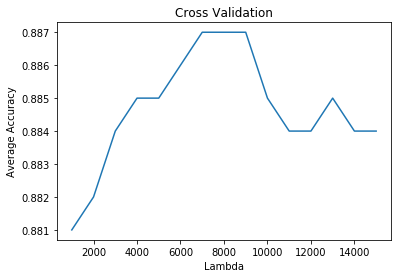

In [16]:
plt.plot(LAMBDAS, cv_accuracies)
plt.xlabel('Lambda')
plt.ylabel('Average Accuracy')
plt.title('Cross Validation')
plt.show()

### Test & Train Accuracy with Optimal Lambda

In [17]:
train_X, train_y = CVData.get_all_X_y()

# Create hypothesis
t1 = time.time()
model = LogisticRegression(train_X, train_y, POSITIVE_LABEL, NEGATIVE_LABEL, optimal_lambda)
t2 = time.time()

# Train Accuracy 
predicted_train_y = model.predict_df(train_X)
train_accuracy = get_accuracy(train_y.values.flatten(), predicted_train_y.values.flatten())

# Test Accuracy
predicted_test_y = model.predict_df(test_X)
test_accuracy = get_accuracy(test_y.values.flatten(), predicted_test_y.values.flatten())

print("Train Accuracy: %f" % train_accuracy)
print("Test Accuracy: %f" % test_accuracy)
print("Training Time (s): " + str(t2-t1))

Train Accuracy: 0.893000
Test Accuracy: 0.900000
Training Time (s): 0.020524978637695312


### Parameters

In [18]:
print("w_0 = " + str(model.w[0]))
print("w = " + str(model.w[1:]))

w_0 = -0.0007261238590916078
w = [ 0.00228753 -0.00218262 -0.02499607 -0.00677616 -0.02156872 -0.04263319
 -0.00888297 -0.00031574 -0.00933602 -0.01046375 -0.02821003  0.00133734
 -0.01630065 -0.03102114 -0.00421849  0.00478879  0.00057688 -0.01515247
 -0.00717007  0.0115508  -0.0079005   0.00312802  0.00437815  0.00472446
 -0.0051537  -0.00910076  0.00018878 -0.01708027 -0.01901705 -0.0054421
  0.00678872 -0.00122225 -0.0034087   0.00794875  0.02455587  0.01430453
  0.00313639  0.01047607  0.00224912  0.00508369  0.00246666  0.00583231
  0.05520182  0.0299953  -0.00031288 -0.00124383  0.01620232  0.00140322
 -0.00097509  0.00852071  0.0171887   0.01673538 -0.01840872  0.01219147
  0.02774324  0.00128359  0.00540749  0.00557576 -0.03186668 -0.01486028
  0.01550594  0.02840391  0.00908849  0.00305927]


## Discussion

1. **Compare the number of parameters for Gaussian Mixtures and Logistic Regression.**

The parameters of the Gaussian Mixture model are π, $μ_1$, $μ_2$, Σ. 

For an input space in $R^n$, $μ_1$ and $μ_2$ are both n-dimensional, π is scalar, and Σ is an n x n matrix. Σ has a symmetrical upper and lower triangle. Thus, all the parameters are:

- π
- $μ_{1i}$ for $0 < i < n$
- $μ_{2i}$ for $0 < i < n$
- $Σ_{ij}$ for $0 < i < n, 0 < j < n, i <= j$

They each correspond to:

- 1 parameter
- n parameters
- n parameters
- 1 + 2 + ... + n = n * (n + 1) / 2 parameters

The total number of parameters in the Gaussian Mixture model is $\frac{n^2}{2} + \frac{5n}{2} + 1$

For our data in the 64-dimensional digits dataset, this equals 2209 parameters.

The parameters of the Logistic Regression model is w and $w_0$ where w is n dimensional and $w_0$ is scalar.

Thus, the total number of parameters in the Logistic Regression model is n + 1. 

For our data above, this equals 65 parameters.

The Gaussian Mixture model is heavily parameterized in comparison to the Logistic Regression model. This shows that the Gaussian Mixture model has less degress of freedom. This makes sense because the Logistic Regression model can represent any conditional distribution $P(x|C_i)$ in the exponential family, where the Gaussian Mixture model only represents one of these possibilities (the Gaussian conditional). 

2. **Compare the amount of computation for both models.**

There are two areas where computation is involved: the complexity involved to learn the parameters, and the complexity involved to predict a value. We will consider both in our analsyis as the computational complexity of learning, and the computational complexity of prediction.

Let's consider the complexity of learning as the asymptotic computational complexity of calculating the parameters as a function of the dimensionality of the data, n, and the number of training samples, m.

For the Gaussian Mixture model, we calculate π by finding the proportion of points that belongs to a class. This is an $O(m)$ operation. We calculate $μ_1$ by taking the average across each dimension for all the points in a class. This is an $O(mn)$ operation. WLOG, this also applies to to $μ_2$. To calculate the covariance matrix we subtract each mean from $X_{y=c_{1}}$ and $X_{y=c_{2}}$ respectively and taking $X^TX$ for each and combining them. Subtracting the mean can be done in $O(m)$ and calculating $X^TX$ can be done by taking a dot product of two m dimensional vectors for n^2 positions in the resulting matrix, an $O(mn^2)$ operation. So, the covariance can be calculated in $O(m) + O(mn^2) = O(mn^2)$.

Finally, combining the above complexities, $O(m) + O(mn) + O(mn^2) = O(mn^2)$ is the computational complexity of learning for the Gaussian Mixture model.

The computational complexity of prediction for the Gaussian Mixture model is simply to take the weights learned and dot them with the input vector and then apply a sigmoid transformation. This is done in $O(n)$.

Now, let's consider the complexity of learning for the logistic regression model. Let's assume that 10 iterations is sufficient for convergence. 

In each iteration, we calculate the hessian, we calculate the gradient, we find the inverse of the hessian, dot the inverse by the gradient, and subtract the result from w to find the new w.

To calculate the hessian, we calculate $X^TRX + λI$ where R is a diagonal matrix with m non-zero elements that represent each training sample's sigmoid probability ($σ_i$) multiplied by its inverse probability ($1-σ_i$). R is calculated in $O(mn)$ since each of the m elements is calculated from the dot product of two n dimensional vectors. To calculate $X^TR$, each column is multiplied by a diagonal element of R. Thus, the computational complexity is $O(mn)$. Then to calculate $X^TRX$ from the previous step, it will take $O(mn^2)$. We know this from our results involving calculating the covariance matrix in the Gaussian Mixture model case. Finally, to add the regularization term is an $O(n)$ operation. In summary, calculating the hessian is an $O(mn) + O(mn^2) + O(n)= O(mn^2) $ operation.

To calculate the gradient, we take all the difference between sigmoid probabilities for each training sample and the y label and dot that with X and add the regularization term. This takes $O(mn) + O(mn) + O(n) = O(mn)$ time.

To calculate the inverse of the n x n hessian matrix, it takes $O(n^3)$. I'm using the result here for the time complexity of naive Gaussian elimination, documented here: http://mathforum.org/library/drmath/view/51908.html. I don't think the goal of this assignment is to discuss the time complexity of Gaussian elimination, so I will use this result freely.

The time complexity of learning for the Logistic Regression model is then $O(mn^2) + O(mn) + O(n^3) = O(mn^2) + O(n^3)$. If $m > n$, which should really be true if you want meaningful results, then the time complexity is simply $O(mn^2)$.

The time complexity of prediction for the Logistic Regression model is the same as the Gaussian result at $O(n)$.

In summary, the time complexity of learning for Gaussian Mixture models and Logistic Regression is $O(mn^2)$ and the time complexity of prediction for both is $O(n)$.

In wall clock time, the results for training both models are as follows:

Gaussian Mixture: 0.0048 seconds

Logistic Regression: 0.0176 seconds

These values may vary from the ones above, since I just took the ones I got on this specific run of the notebook.

The wall clock times make sense because the logistic regression does up to 10 more iterations, with each iteration in $O(mn^2)$. These finite iterations make no difference to the asymptotic complexity, but in wall clock time the difference is clear.

3. **Compare the results for both models.**

The Gaussian Mixture model gave us:

Train Accuracy: 0.884000
Test Accuracy: 0.890909

The Logistic Regression model gave us:

Train Accuracy: 0.894000
Test Accuracy: 0.900000

The logistic regression model fits the data slightly better.

4. **Compare the expressivity of KNN and linear seperators. Discuss under what circumstances each type of seperator is expected to perform best.**

K-Nearest Neighbours is able to express complex non-linear hypotheses as a function of the training data. In KNN, the input space is partitioned with various degrees of smoothing as we increase k. KNN's decision boundary can take on any form since it is non-parametric.

KNN is expected to do well if the training data is very representative of the true distribution. Although, if there are many training points, this may result in decreased speed when forming predictions since many more comparisons need to be made. KNN evaluates all features as equally important (has no concept of feature importance), so if this is not true, KNN may not be well suited to the problem. KNN is also not suited to the problem if there are linearities between features, since KNN does not capture these.

The Gaussian Mixture model is able to express hypotheses with a linear decision boundary between two classes of data that are conditionally normally distributed around $μ_1$ and $μ_2$ with the same covariance matrix of Σ.

The Gaussian Mixture model is expcted to perform best if the conditional normality conditions are satisfied and both classes have the same covariance matrix. The model can work best when the two classes can be linearly seperated. The model is effective at capturing linearity between features. The model is also robust to irrelevant features since it can assign those features a weight close to zero if they are less important.

The Logistic Regression model is able to express hypotheses with a linear decision boundary between two classes of data that are conditionally distributed according to some unknown exponential distribution. This model is effective for data that is linearly seperable and follows some exponential distribution. The model is effective at capturing linearities between features and is also robust to irrelevant features. Logistic Regression should be used when there is a strong belief that the features are dependent on the class, and the features of both classes are different from one another. 

5. **What can explain the results of KNN in comparison to Gaussian Mixtures and Logistic Regression.**

KNN gave us a test accuracy of 0.727 where both Gaussian Mixture and Logistic Regression gave us close to 0.9 test accuracy. The linear seperators vastly outperformed KNN. 

The reason for this can be understood by taking a look what the data represents. Each feature represents the number of dark pixels found in a 4x4 patch. Each feature is spatially correlated to one another. For the digits 5 and 6, we would expect that some features in tandem could define a 5, where the prescence of other features in tandem could represent a 6. We expect the features to have linearities between each other. KNN is unable to capture these linearities, where the linear seperators are able to create a linear decision boundary defined between features. 

Furthermore, we would expect some features to be more important than other features. For example, if we superimpose a 5 on top of a 6, we can tell that most of the shape may be identical except for the bottom left of the 6 and the the 5. This may lead these specific feature to be more important than the rest. Generally, we would also expect the features along the perimeter of the image to also be less important.

We can verify this by taking a look at the weights we learned. In the logistic regression model, the 8th weight represents the weight for the feature in the top right corner of the image. This value is -9.17977578e-06. This is the lowest magnitude value from all the features. The linear seperators are able to learn this feature is less important where the KNN model gives this feature the same importance.

These factors contribute to the linear seperators outperforming KNN on this dataset.

# Question 2b

Consider a set of data D that is linearly seperable. 

In a logistic regression, we minimize the negative log likelihood to form a linear decision boundary. For the data D, the weights, $w$, that would minimize the negative log likelihood form a decision boundary, $w^Tx = 0$, that linearly seperates the data D perfectly, and whose weights tend to infinity. 

The reason for this is as follows: Imagine that we have weights w for a linear boundary that accomplishes perfect classification on D. We can minimize the negative log likelihood further by multiplying all the weights by some c. This will keep the boundary in the same place but increase the magnitude of $w^Tx$ for any points. Thus, the sigmoid function will tend to a step function or threshold function with each iteration. With each iteration, we expect the magnitude of weights to increase.

Using this knowledge, we can conduct an experiment to see if the training data is linearly seperable. We should train a logistic regression classifier on the training data and check to see if the mode has 100% on the train set. If it is true, we can confirm that the data is linearly seperable. A training accuracy of 100% is enough to prove the data is linearly seperable since the linear decision boundary classifies each point perfectly. For interest, I would like to also take a look at the weights themselves as well as I increase the number of iterations.

A natural question is what should our regularization parameter be? 

For a linearly seperable dataset, regularization should not matter since the magnitude of the weights only affects how the sigmoid function looks and should not alter the linear boundary from its optimum. 

However, we want to avoid a hessian matrix with no inverse so we will use a small value for lambda in the logistic regression.

## Experiment

In [19]:
train_X, train_y = CVData.get_all_X_y()

NUM_ITERS = [10, 20, 30, 40]

weight_norms = []
train_accuracies = []

for num in tqdm_notebook(NUM_ITERS):
    
    # Create hypothesis
    model = LogisticRegression(train_X, train_y, POSITIVE_LABEL, NEGATIVE_LABEL, 10, max_iters=num, threshold=0.001)

    # Train Accuracy 
    predicted_train_y = model.predict_df(train_X)
    train_accuracy = get_accuracy(train_y.values.flatten(), predicted_train_y.values.flatten())

    train_accuracies.append(train_accuracy)
    weight_norms.append(norm(model.w))



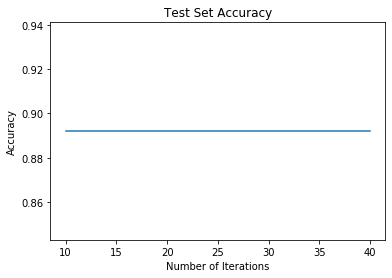

In [20]:
plt.plot(NUM_ITERS, train_accuracies)
plt.xlabel('Number of Iterations')
plt.ylabel('Accuracy')
plt.title('Test Set Accuracy')
plt.show()

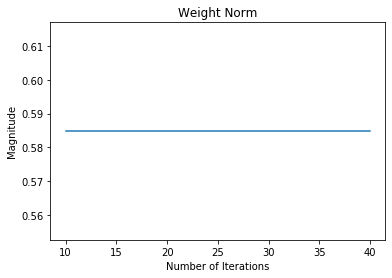

In [21]:
plt.plot(NUM_ITERS, weight_norms)
plt.xlabel('Number of Iterations')
plt.ylabel('Magnitude')
plt.title('Weight Norm')
plt.show()

From the above graphs, it is clear that the training set is not linearly seperable.

The accuracy does not reach 100% and the weights do not increase as we expect them to, instead the logistic regression converges to certain weights, and the train accuracy is below 0.9.